## Example Notebook

Examples used for EUFN Talk.


In [ ]:
%load_ext autoreload
%autoreload 2


from fibsem import utils, acquire, movement
from fibsem.structures import BeamType, Point, FibsemImage, FibsemStagePosition

import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
# connect to microscope
microscope, settings = utils.setup_session(manufacturer="Tescan", ip_address="localhost")


### Imaging

Take an image with both beams at different hfws, and plot.


In [ ]:
settings.image.beam_type = BeamType.ION
settings.image.autocontrast = False
settings.image.save = True
settings.image.save_path = os.path.join(os.getcwd(), "demo", "imaging")
os.makedirs(settings.image.save_path, exist_ok=True)


settings.image.hfw = 80e-6

hfws = [80e-6, 150e-6, 400e-6, 900e-6]
for i, hfw in enumerate(hfws):

    settings.image.hfw = hfw
    settings.image.label = f"hfws_{i:02d}"

    ib_image = acquire.new_image(microscope, settings.image)


### Loading Images, Reading Metadata

In [ ]:
# loading images

import glob
from fibsem.structures import FibsemImage

filenames = sorted(glob.glob(os.path.join(settings.image.save_path, "hfws*.tif")))

# plot wiht subplot
fig, axes = plt.subplots(1, len(filenames), figsize=(15, 5))
for fname in filenames:

    image = FibsemImage.load(fname)
    ax = axes[filenames.index(fname)]
    ax.imshow(image.data, cmap="gray")
    ax.set_title(f"{image.metadata.image_settings.label} - {image.metadata.image_settings.hfw*1e6:.0f} um")
    ax.axis("off")

# subplot width
plt.tight_layout()

# hwidth
plt.subplots_adjust(wspace=0.01)

# save fig, dpi = 300
plt.savefig(os.path.join(settings.image.save_path, "hfws.png"), dpi=300)

plt.show()
    


### Stage Movement

Basic stage movement, and plotting.

In [ ]:
# image settings
settings.image.hfw = 150e-6
settings.image.save = True
settings.image.save_path = os.path.join(os.getcwd(), "demo", "movement")
os.makedirs(settings.image.save_path, exist_ok=True)

# acquire images with both beams
settings.image.label = "pre-movement"
eb_image0, ib_image0 = acquire.take_reference_images(microscope, settings.image)

# move stage by 50um
move_position = FibsemStagePosition(x=50e-6)
microscope.move_stage_relative(move_position)

# acquire images with both beams
settings.image.label = "post-movement"
eb_image1, ib_image1 = acquire.take_reference_images(microscope, settings.image)



# plot images
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes[0][0].imshow(eb_image0.data, cmap="gray")
axes[0][0].set_title("Electron (pre-movement)")
# crosshair, centre, yellow
axes[0][0].plot(eb_image0.data.shape[1]/2, eb_image0.data.shape[0]/2, "y+", ms=20)
axes[0][1].imshow(ib_image0.data, cmap="gray")
axes[0][1].set_title("Ion (pre-movement)")
axes[0][1].plot(ib_image0.data.shape[1]/2, ib_image0.data.shape[0]/2, "y+", ms=20)

axes[1][0].imshow(eb_image1.data, cmap="gray")
axes[1][0].set_title("Electron (post-movement)")
# crosshair, centre, yellow
axes[1][0].plot(eb_image1.data.shape[1]/2, eb_image1.data.shape[0]/2, "y+", ms=20)
axes[1][1].imshow(ib_image1.data, cmap="gray")
axes[1][1].set_title("Ion (post-movement)")
axes[1][1].plot(ib_image1.data.shape[1]/2, ib_image1.data.shape[0]/2, "y+", ms=20)

# axes off
for ax in axes.flatten():
    ax.axis("off")

# wspace
plt.subplots_adjust(hspace=0.07, wspace=0.01)

# save fig, dpi = 300
plt.savefig(os.path.join(settings.image.save_path, "movement.png"), dpi=300)

plt.show()


## Scripting Examples

### Rotation Example

Rotate the stage, and take an image at each step (15deg).

In [ ]:
from fibsem import utils, acquire
from fibsem.structures import FibsemStagePosition
import os

# connect to microscope
microscope, settings = utils.setup_session(manufacturer="Tescan", ip_address="localhost")

# image settings
settings.image.save = True 
settings.image.save_path = os.path.join(os.getcwd(), "demo", "rotation")
os.makedirs(settings.image.save_path, exist_ok=True)

rot = 30    # rotation angle
for i in range(360//rot):
    
    # move stage relative
    microscope.move_stage_relative(FibsemStagePosition(r=np.deg2rad(rot)))

    # acquire images with both beams
    settings.image.label = f"rot_{i:03d}"
    eb_image, ib_image = acquire.take_reference_images(microscope, settings.image)

## Tiling Example

Take a 3x3 tile scan with the ION beam and plot.

In [ ]:
from fibsem import utils, acquire
from fibsem.structures import FibsemStagePosition
import os

# connect to microscope
microscope, settings = utils.setup_session(manufacturer="Tescan", ip_address="localhost")

# image settings
settings.image.hfw = 80e-6
settings.image.resolution = [1024, 1024]
settings.image.beam_type = BeamType.ION
settings.image.save = True 
settings.image.save_path = os.path.join(os.getcwd(), "demo", "tile")
os.makedirs(settings.image.save_path, exist_ok=True)

# tile settings
dx, dy = settings.image.hfw, settings.image.hfw
nrows, ncols = 3, 3

# tile
initial_position = microscope.get_stage_position()
for i in range(nrows):

    # restore position
    microscope.move_stage_absolute(initial_position)
    # stable movement dy
    microscope.stable_move(dx=0, dy=dy*i, settings=settings, beam_type=BeamType.ION)

    for j in range(ncols):
    
        # stable movement dx
        microscope.stable_move(dx=dx, dy=0, settings=settings, beam_type=BeamType.ION)
        # acquire images with both beams
        settings.image.label = f"tile_{i:03d}_{j:03d}"
        ib_image = acquire.new_image(microscope, settings.image)

In [ ]:
# plot tiles
import glob
filenames = sorted(glob.glob(os.path.join(settings.image.save_path, "tile*.tif")))


fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
for fname in filenames:

    image = FibsemImage.load(fname)
    ax = axes[filenames.index(fname)//ncols][filenames.index(fname)%ncols]
    ax.imshow(image.data, cmap="gray")
    ax.axis("off")

# subplot width
plt.tight_layout()

# hwidth
plt.subplots_adjust(hspace=0.01,wspace=0.01)

# save fig, dpi = 300
plt.savefig(os.path.join(settings.image.save_path, "tiles.png"), dpi=300)

plt.show()

## Serialisation

Writing / Reading structures to disk

In [ ]:
from fibsem.structures import MicroscopeState
os.makedirs("demo/state", exist_ok=True)

# get state
print("\nCurrent microscope state:")
state = microscope.get_current_microscope_state()

# save to yaml
print("\nSerialise microscope state")
state_dict = state.__to_dict__()
utils.save_yaml("demo/state/state.yaml", state_dict)

# load from yaml
print("\nDeserialise microscope state")
state_dict = utils.load_yaml("demo/state/state.yaml")
state = MicroscopeState.__from_dict__(state_dict)

## Model Deployment

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2023-05-30 18:23:54,090 — root — INFO — connect_to_microscope:3995 — Connected to Demo Microscope
2023-05-30 18:23:54,091 — root — INFO — connect_to_microscope:3996 — Microscope client connected to model Demo with serial number 123456 and software version 0.1
2023-05-30 18:23:54,092 — root — INFO — setup_session:229 — Finished setup for session: demo_2023-05-30-06-23-54PM
2023-05-30 18:23:54,862 — root — INFO — autocontrast:4030 — Autocontrast: BeamType.ION
2023-05-30 18:23:54,863 — root — INFO — acquire_image:4008 — Acquiring image: BeamType.ION


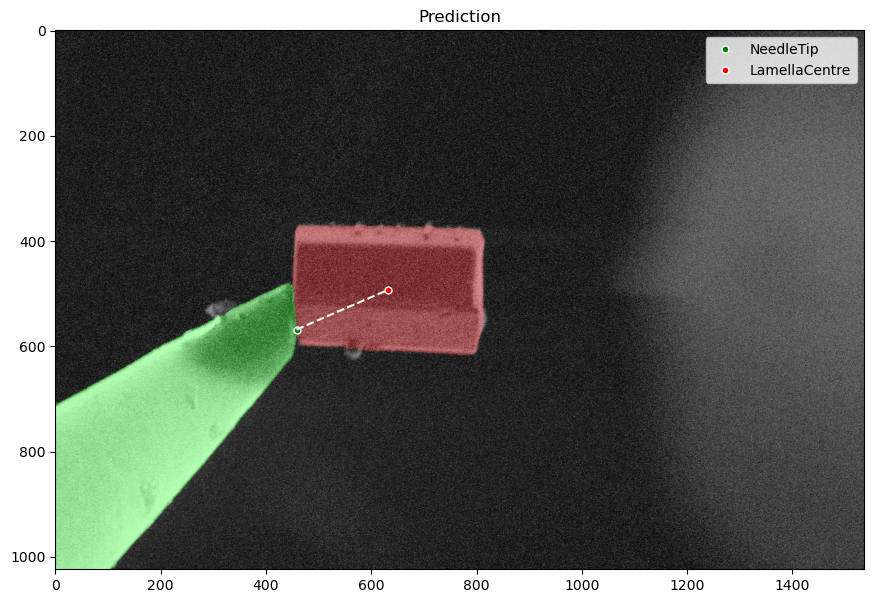

In [3]:
from fibsem import utils, acquire
from fibsem.detection import detection
from fibsem.detection import detection
from fibsem.segmentation.model import load_model
from fibsem.structures import BeamType

# connect to microscope
microscope, settings = utils.setup_session(manufacturer="Demo", ip_address="localhost")

# model parameters
checkpoint = "../fibsem/segmentation/models/model4.pt"
encoder = "resnet34"
num_classes = 3

# load model
model = load_model(checkpoint=checkpoint, encoder=encoder, nc=num_classes) # type: ignore

# acquire image
settings.image.beam_type = BeamType.ION
image = acquire.new_image(microscope, settings.image)

# detect features
features = [detection.NeedleTip(), detection.LamellaCentre()] 
det = detection.detect_features(image=image.data, model=model, 
                                features=features,                      # type: ignore        
                                pixelsize=image.metadata.pixel_size.x)  # type: ignore 

# plot detection
detection.plot_detection(det)

In [ ]:
# model
%load_ext autoreload
%autoreload 2

from fibsem import utils, acquire
from fibsem.detection import detection
from fibsem.segmentation import model
from fibsem.detection import detection
from fibsem.detection.detection import DetectedFeatures
from fibsem.segmentation import model as fibsem_model
from fibsem.segmentation.model import load_model
from fibsem.structures import (
    BeamType,
    FibsemImage,
    Point,
)

# connect to microscope
microscope, settings = utils.setup_session(manufacturer="Demo", ip_address="localhost")

# model parameters
checkpoint = "../fibsem/segmentation/models/model4.pt"
encoder = "resnet34"
num_classes = 3

# load model
model = load_model(checkpoint=checkpoint, encoder=encoder, nc=num_classes) # type: ignore

# acquire image
settings.image.beam_type = BeamType.ION
image = acquire.new_image(microscope, settings.image)
image = FibsemImage.load("../fibsem/detection/test_image.tif")

# detect features
features = [detection.NeedleTip(), detection.LamellaCentre()] 
det = detection.detect_features(image=image.data, model=model, 
                                features=features, pixelsize=25e-9) # type: ignore 

# plot detection
detection.plot_detection(det)



In [ ]:
from fibsem import acquire
from fibsem.structures import ImageSettings

# image settings
image_settings = ImageSettings(
    resolution = [1536, 1024], 
    dwell_time=1.0e-6,
    hfw=80-6,
    beam_type=BeamType.ELECTRON,
    autocontrast=True,
)

# acquire image
image = acquire.new_image(microscope, image_settings)

In [1]:
from fibsem.structures import (FibsemPattern, 
                    FibsemPatternSettings)

pattern = FibsemPatternSettings(
    pattern=FibsemPattern.Annulus,
    radius=20e-6,
    depth=10e-6,
    thickness=5e-6
)





SyntaxError: invalid syntax (4200631817.py, line 8)

In [ ]:
Rect, 20, 50
Circile, 10
Trench, 40, 10, 10

### EUFN Live Example - Focus Stacking



In [17]:
import os, logging
import matplotlib.pyplot as plt
import numpy as np
from fibsem import utils, acquire
from fibsem.structures import BeamType

# connect to microscope
microscope, settings = utils.setup_session(manufacturer="Thermo", ip_address="localhost") 

# setup
microscope.set("on", True, BeamType.ELECTRON )
microscope.set("on", True, BeamType.ION )

# image settings
settings.image.resolution = [6144, 4096]
settings.image.dwell_time = 200e-9
settings.image.hfw = 500e-6
settings.image.autocontrast = True
settings.image.save = True
settings.image.save_path = os.path.join(os.getcwd(), "demo", "eufn")
os.makedirs(settings.image.save_path, exist_ok=True)
# NB: no line integration

wds = np.arange(0.004, 0.0048, 50e-6)
images = []

logging.info(f"Acquiring {len(wds)} images")

for wd in wds:

    logging.info(f"Working distance: {wd:4e}")
    microscope.set("working_distance", wd, BeamType.ELECTRON)

    settings.image.label = f"wd_{wd:.4e}".replace(".", "_")

    image = acquire.new_image(microscope, settings.image)

    images.append(image)
    logging.info(f"-"*200)

# lapacian pyramid
# TODO: stacking.py
# stacking.image_stacking(images)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2023-06-07 19:27:24,833 — root — INFO — connect_to_microscope:4000 — Connected to Demo Microscope
2023-06-07 19:27:24,835 — root — INFO — connect_to_microscope:4001 — Microscope client connected to model Demo with serial number 123456 and software version 0.1
2023-06-07 19:27:24,838 — root — INFO — setup_session:229 — Finished setup for session: demo_2023-06-07-07-27-24PM
2023-06-07 19:27:24,843 — root — INFO — set:4392 — Setting on to True (BeamType.ELECTRON)
2023-06-07 19:27:24,846 — root — WARNING — set:4437 — Unknown key: on (BeamType.ELECTRON)
2023-06-07 19:27:24,849 — root — INFO — set:4392 — Setting on to True (BeamType.ION)
2023-06-07 19:27:24,852 — root — WARNING — set:4437 — Unknown key: on (BeamType.ION)
2023-06-07 19:27:24,874 — root — INFO — <module>:34 — Acquiring 16 images
c:\Users\pcle0002\Documents\repos\fibsem\example\demo\eufn
2023-06-07 19:27:24,878 — root — INFO — <module>:39 — 

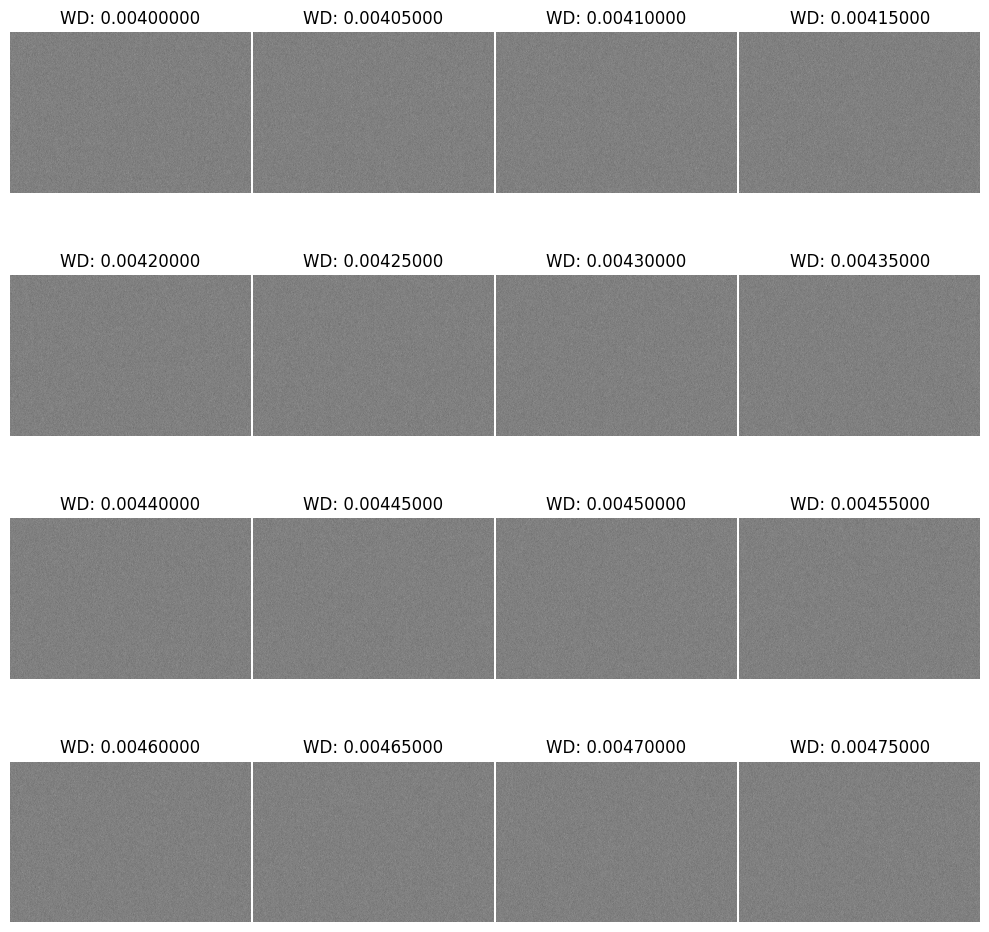

In [10]:

# plot images as grid
fig, axes = plt.subplots(len(images)//4, len(images)//4, figsize=(10, 10))

for i, image in enumerate(images):
    ax = axes[i//4, i%4]
    ax.imshow(image.data, cmap="gray")
    ax.set_title(f"WD: {wds[i]:.08f}")
    ax.axis("off")
# subplot width
plt.tight_layout()

# hwidth
plt.subplots_adjust(hspace=0.01,wspace=0.01)

plt.show()